### This should Python 2

In [12]:
import sys
print (sys.version)

2.7.10 (default, Oct 14 2015, 16:09:02) 
[GCC 5.2.1 20151010]


In [1]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy

import random
import pickle

# works for python 2, not python 3
import itertools
from itertools import ifilter

import time

from scipy import stats


from scipy.interpolate import griddata
from matplotlib.mlab import griddata

%matplotlib inline
plt.style.use('ggplot')
#matplotlib.rcParams['figure.figsize'] = (18,10)
matplotlib.rcParams['figure.figsize'] = (9,5)
matplotlib.rcParams['font.size'] = 18
matplotlib.rc('lines',linewidth = 3)

# Simple example of TPG model

### Define the number of gridcells for the TM

In [2]:
gridsizeOneDim = 3

print "Truncated map (TM) is defined on a {0}x{0} grid, \
with thresholds distributed uniformaly in the probability space.".format(gridsizeOneDim)

Truncated map (TM) is defined on a 3x3 grid, with thresholds distributed uniformaly in the probability space.


### Create the values defining gridcell boundaries of the TM, here they are called thresholds

In [3]:
bigNumber = 30.0
#bigNumber is an absolute practical limit for a Gaussian random field (GRF) with zero-mean and unit-variance

def createCellThresholds(gridsizeOneDim):
    gridNumberCells = gridsizeOneDim**2
    probalityIntervals = np.arange(0,1,1/float(gridsizeOneDim))
    thresholds = [-bigNumber] + [scipy.stats.norm.ppf(elem, 0, 1) for elem in probalityIntervals][1:]
    thresholds.append(bigNumber)
    return (thresholds, probalityIntervals)
thresholds,_ = np.array(createCellThresholds(gridsizeOneDim))

### Define the set of categories

In [4]:
facies =  [1,2,3]

print "Categories presented on the TM belong to the set {{{0}}}.".format(", ".join(map(str, facies)))

Categories presented on the TM belong to the set {1, 2, 3}.


### Simulate a TM and plot it in the state space

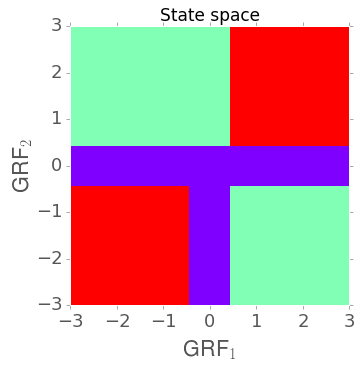

In [5]:
np.random.seed(seed=3)
tmapFlat  = np.random.choice(facies,gridsizeOneDim**2)

fig = plt.figure()

gridX, gridY = np.meshgrid(thresholds,thresholds)

plt.axes().set_aspect('equal')
plt.pcolormesh(gridX, gridY, np.reshape(tmapFlat , [gridsizeOneDim]*2),  cmap=plt.get_cmap('rainbow'))

bigLimVizual = 3
plt.axis((-bigLimVizual,bigLimVizual,-bigLimVizual,bigLimVizual))

textSizeHere = 17
plt.title("State space", size = textSizeHere)
plt.xlabel("GRF$_1$")
plt.ylabel("GRF$_2$")

#fig.savefig('simpleExample.png')

### Define covariance function (here it is the same for both GRFs), ranges for both GRFs; store in a dictionary

In [6]:
dictVariograms = {"Gaussian1" : {'a_x' : 30.0, 'a_y' :30.0}, \
                  "Gaussian2" : {'a_x' : 35.0, 'a_y' :110.0},
                  "covFunc" : lambda h : np.exp(-3*h**1.999)}

### Plot variograms GRF1, GRF2 in both axes:

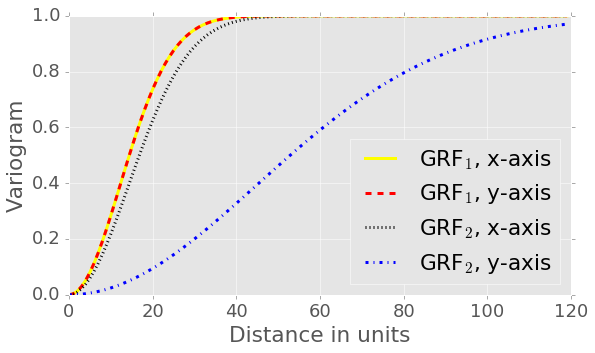

In [7]:
lagsToPlot = np.arange(0,120)
covFunc = dictVariograms["covFunc"]

plt.plot(lagsToPlot, [1 - covFunc(h/dictVariograms['Gaussian1']['a_x']) for h in lagsToPlot],\
         label="GRF$_1$, x-axis", color = 'yellow')
plt.plot(lagsToPlot, [1 - covFunc(h/dictVariograms['Gaussian1']['a_y']) for h in lagsToPlot],\
         label="GRF$_1$, y-axis",linestyle='--', color = 'red')
plt.plot(lagsToPlot, [1 - covFunc(h/dictVariograms['Gaussian2']['a_x']) for h in lagsToPlot],\
         label="GRF$_2$, x-axis",linestyle=':', color = 'black')
plt.plot(lagsToPlot, [1 - covFunc(h/dictVariograms['Gaussian2']['a_y']) for h in lagsToPlot],\
         label="GRF$_2$, y-axis",linestyle='-.', color = 'blue')
plt.legend(loc=0)
plt.xlabel('Distance in units')
plt.ylabel('Variogram')
None

### Define size of  the TPG simulation field 

In [8]:
sizeFieldX = 15
sizeFieldY = 50

print "Realization size equals {0}x{1}".format(sizeFieldX,sizeFieldY)

Realization size equals 15x50


### This part computes the covariance matrices of the GRFs for the given field size

In [9]:
fieldX, fieldY = np.meshgrid(range(sizeFieldX), range(sizeFieldY))

i1, i2 = np.meshgrid(range((sizeFieldX*sizeFieldY)) ,\
                         range((sizeFieldX*sizeFieldY)))

fieldXFlatten = fieldX.ravel()
fieldYFlatten = fieldY.ravel()

covMatrix_G1 = np.zeros((sizeFieldX*sizeFieldY,sizeFieldX*sizeFieldY))
covMatrix_G2 = np.zeros((sizeFieldX*sizeFieldY,sizeFieldX*sizeFieldY))


for cell1, cell2 in zip( i1.flatten(),i2.flatten()):

    cell1_X = fieldXFlatten[cell1]
    cell2_X = fieldXFlatten[cell2]
    
    cell1_Y = fieldYFlatten[cell1]
    cell2_Y = fieldYFlatten[cell2]
    
    h_G1 = np.sqrt((cell1_X.astype(float) - cell2_X.astype(float))**2/dictVariograms['Gaussian1']['a_x']**2 \
                 + (cell1_Y.astype(float) - cell2_Y.astype(float))**2/dictVariograms['Gaussian1']['a_y']**2 )
    
    h_G2 = np.sqrt((cell1_X.astype(float) - cell2_X.astype(float))**2/dictVariograms['Gaussian2']['a_x']**2 \
                 + (cell1_Y.astype(float) - cell2_Y.astype(float))**2/dictVariograms['Gaussian2']['a_y']**2 )
    covMatrix_G1[cell1,cell2] = covFunc(h_G1)
    covMatrix_G2[cell1,cell2] = covFunc(h_G2)

### This part simulates the GRFs for the given field size

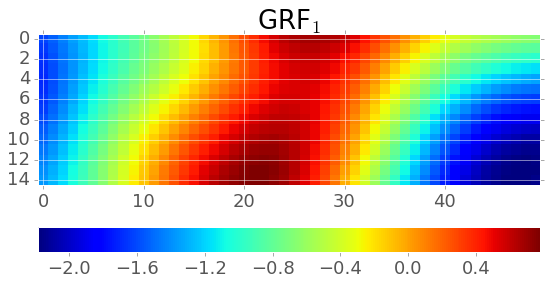

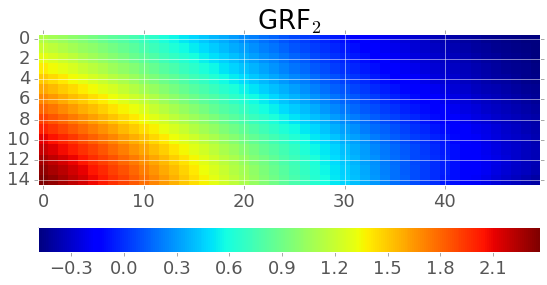

In [10]:
np.random.seed(seed=5)

grfFlat_G1 = np.random.multivariate_normal(np.zeros(sizeFieldX*sizeFieldY), covMatrix_G1, 1).flatten()
grfFlat_G2 = np.random.multivariate_normal(np.zeros(sizeFieldX*sizeFieldY), covMatrix_G2, 1).flatten()

grf_G1= grfFlat_G1.reshape((sizeFieldY,sizeFieldX)).T
grf_G2= grfFlat_G2.reshape((sizeFieldY,sizeFieldX)).T

plt.figure()
plt.title("GRF$_1$")
plt.axes().set_aspect('equal')
plt.imshow(grf_G1, interpolation="nearest")
plt.colorbar(orientation='horizontal')

plt.figure()
plt.title("GRF$_2$")
plt.axes().set_aspect('equal')
plt.imshow(grf_G2, interpolation="nearest")
plt.colorbar(orientation='horizontal')
None

### This part vizualizes the TPG realization for the given TPG model and the simulated GRFs:

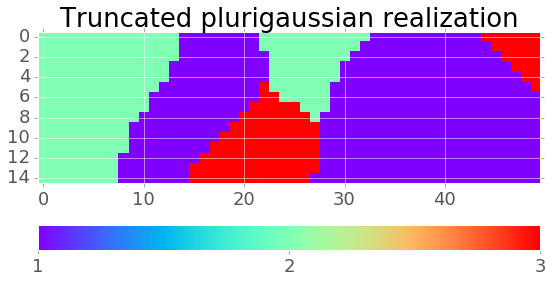

In [11]:
tmapInd_G1 = np.argmax(thresholds - np.tile(grfFlat_G1, (len(thresholds),1)).T >0, axis = 1)-1
tmapInd_G2 = np.argmax(thresholds - np.tile(grfFlat_G2, (len(thresholds),1)).T >0, axis = 1)-1

tmap = np.reshape(tmapFlat, [len(thresholds)-1]*2)

tgrfFlat = tmap[tmapInd_G1, tmapInd_G2]
tgrf = tgrfFlat.reshape((sizeFieldY,sizeFieldX)).T

plt.figure()
plt.title("Truncated plurigaussian realization")
plt.imshow(tgrf, interpolation="nearest",  cmap=plt.get_cmap('rainbow'))
plt.colorbar(orientation='horizontal', ticks=facies)
None